In [4]:
from IPython import display
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg
import math
from scipy.sparse import csr_matrix
import time

# CPFM Linear Solver Performance

This notebook looks at solver performances of different linear solver algorithms using the `scipy.sparse.linalg` library (with a tolerance of $1e-10$). This work aims to optimize of the linear solver to be used in the $2^{nd}$ step of the CPFM algorithm corresponding to solving the Poisson equation $\nabla^2 {\bf{\phi}} = c {\bf \rho} \, \equiv$ `A @ phi =`$c$ `rho` $, \; c \in \mathbb{R}$. 

Parameters of interest are:

- Number of iterations required
- Time per iteration
- Solution Error

This information allows for the selection of the most efficient solver. LHS matrices will be the discretization matrices of the 2D and 3D Laplacian equation. The RHS vectors will be randomly generated via `numpy.random` to represent the 2D or 3D flattened charge density vector $\rho(\vec{x})$

**Note :** The Conjugate Gradient (CG) and Biconjugate Gradient (BCG) methods will not be considered as $A$ is not positive definite, nor is it symmetric for non-square domains. 

<br>

**Note :** Another question to be answered is a bit non-conventional and would normally be advised against: When, if at all, does inverting $A$ decrease computational cost? 

To justify this question, please look at the $2^{nd}$ step of the algorithm. The Poisson equation will be solved for $\phi$ during each time-step. If the inverse of $A$ is known, then the exact solution to $A \phi = c \rho$ becomes $\phi = c A^{-1} \rho$. Given that $A^{-1}$ would be stored as another matrix, say $B$, throughout the simulation, therefore reducing the $2^{nd}$ step of the CPFM agorithm to a matrix-vector product: $\phi = c B \rho$. Thus, considering that inverting a matrix is expensive (ranging from $\mathcal{O}(n^{~2.4})$ to $\mathcal{O}(n^{3})$ depending on the inversion algorithm used) but not infinitely so, there must be a number of time-steps $N_t$ for which a single matrix inversion operation is faster than using an iterative solver $N_t$ times. 

In [5]:
# Callback functions required to see number of iterations 
    # from https://stackoverflow.com/questions/29747043/retrieving-number-of-iterations-that-ran-for-sparse-linear-solver-in-scipy

def iterations_gmres(A, b):
    num_iters = 0
    
    def callback(xk):
        nonlocal num_iters
        num_iters+=1

    x,status = scipy.sparse.linalg.gmres(A, b, tol=1e-10, callback=callback)
    return x,status,num_iters

def iterations_lgmres(A, b):
    num_iters = 0
    
    def callback(xk):
        nonlocal num_iters
        num_iters+=1

    x,status = scipy.sparse.linalg.lgmres(A, b, tol=1e-10, callback=callback)
    return x,status,num_iters

def iterations_minres(A, b):
    num_iters = 0
    
    def callback(xk):
        nonlocal num_iters
        num_iters+=1

    x,status = scipy.sparse.linalg.minres(A, b, tol=1e-10, callback=callback)
    return x,status,num_iters

def iterations_qmr(A, b):
    num_iters = 0
    
    def callback(xk):
        nonlocal num_iters
        num_iters+=1

    x,status = scipy.sparse.linalg.qmr(A, b, tol=1e-10, callback=callback)
    return x,status,num_iters


# For 2D

To construct the 2D Laplacian discretization matrix $A$, the function `laplace_matrix_2D_RD()` from the module `CPFM_2D.py` will be used, which will allow for the inspection of effects of domain shape on solver efficiency. Three domain shapes will be considered: square (e.g. $A$ is $100 \times 100$), wide rectangle (e.g. $A$ is $200 \times 50$), and tall rectangle (e.g. $A$ is $50 \times 200$). In all cases, to allow for fair comparison (matrix dimensions must be equivalent), the number of grid cells on each domain must be the same.  

In [3]:
def laplace_matrix_2D_RD(Nx, Ny):
    """
    Creates the 2D Laplacian discretization matrix for a rectangular domain,
        thereby allowing for cases where Nx =/= Ny 
    Input: Nx & Ny (int), number of grid points on x- & y-axes
    Output: A_matrix (float array), 2D Laplacian discretization matrix
    """
    # initialize the Laplacian discretization matrix
    A_matrix = np.zeros((Nx*Ny, Nx*Ny))
    
    # iterate over the main diagonal
    for i in range(Nx*Ny):
        
        A_matrix[i][i] = -4 # coefficient for current cell x_i,j 
        
        if (i > 0):
            A_matrix[i-1][i] = 1 # coefficient for right neighbor x_i+1,j 
            
            if (((i + 1) % Ny == 1) and (i < Nx * Ny - 1)):
                A_matrix[i-1][i] = 0 # remove non-existent right neighbor x_i+1,j 
                                        # when reaching the end of a row       
        if (i < Nx * Ny) and (i > 0):
            A_matrix[i][i-1] = 1 # coefficient for left neighbor x_i-1,j 
            
        if (((i + 1) % Ny == 1) and (i > 2)):
            A_matrix[i][i-1] = 0 # remove non-existent left neighbor x_i-1,j 
                                        # when reaching the end of a row
                
    # np.diag() to add coefficients for top (x_i,j-1) and bottom (x_i,j+1) neighbors respectively       
    A_matrix += np.diag(np.ones(Nx * Ny - Ny), -Ny) + np.diag(np.ones(Nx * Ny - Ny), Ny)
  
    return A_matrix

In [4]:
# tested domain sizes as (Na, Nx, Ny) 
dimension_list = [(10, 5, 20), (20, 10, 40), (40, 20, 80), (60, 30, 120), (80, 40, 160) , (100, 50, 200), (120, 60, 240), (140, 70, 280), (160, 80, 320), (180, 90, 360)]  


In [5]:
# initialize plotting arrays
Na_array = np.array([])
iter_square_gmres = np.array([]) # GMRES
time_square_gmres = np.array([])
e_RMS_square_gmres = np.array([])
iter_rect_1_gmres = np.array([])
time_rect_1_gmres = np.array([])
e_RMS_rect_1_gmres = np.array([])
iter_rect_2_gmres = np.array([])
time_rect_2_gmres = np.array([])
e_RMS_rect_2_gmres = np.array([])
iter_square_lgmres = np.array([]) # LGMRES
time_square_lgmres = np.array([])
e_RMS_square_lgmres = np.array([])
iter_rect_1_lgmres = np.array([])
time_rect_1_lgmres = np.array([])
e_RMS_rect_1_lgmres = np.array([])
iter_rect_2_lgmres = np.array([])
time_rect_2_lgmres = np.array([])
e_RMS_rect_2_lgmres = np.array([])
iter_square_minres = np.array([]) # MinRES
time_square_minres = np.array([])
e_RMS_square_minres = np.array([])
iter_rect_1_minres = np.array([])
time_rect_1_minres = np.array([])
e_RMS_rect_1_minres = np.array([])
iter_rect_2_minres = np.array([])
time_rect_2_minres = np.array([])
e_RMS_rect_2_minres = np.array([])
iter_square_qmr = np.array([]) # QMR
time_square_qmr = np.array([])
e_RMS_square_qmr = np.array([])
iter_rect_1_qmr = np.array([])
time_rect_1_qmr = np.array([])
e_RMS_rect_1_qmr = np.array([])
iter_rect_2_qmr = np.array([])
time_rect_2_qmr = np.array([])
e_RMS_rect_2_qmr = np.array([])


for i in range(len(dimension_list)):
    
    Na, Nx, Ny = dimension_list[i]
    
    assert(Na**2 == Nx*Ny), "Number of square and rectangle domain grid cells do NOT match..."
    
    # construct random RHS vector
    vec_RHS = np.random.rand(Na**2)
    
    # construct sparse (CSR) square domain Laplacian discretization matrix
    A_square = laplace_matrix_2D_RD(Na, Na)
    A_square_sparse = scipy.sparse.csr_matrix(A_square)
    
    # construct sparse (CSR) wide rectangular domain (rect 1) Laplacian discretization matrix
    A_rect_1 = laplace_matrix_2D_RD(Nx, Ny)
    A_rect_1_sparse = scipy.sparse.csr_matrix(A_rect_1)
    
    # construct sparse (CSR) tall rectangular domain (rect 2) Laplacian discretization matrix
    A_rect_2 = laplace_matrix_2D_RD(Ny, Nx)
    A_rect_2_sparse = scipy.sparse.csr_matrix(A_rect_2)
    
    
    # Data generation/collection portion : 
    Na_array = np.append(Na_array, Na)
    
    # For GMRES:
    # Square GMRES
    start = time.time() # start time
    solution_gmres, s_gmres, iter_gmres = iterations_gmres(A_square_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_sparse @ solution_gmres)**2))
    
    iter_square_gmres = np.append(iter_square_gmres, iter_gmres)
    time_square_gmres = np.append(time_square_gmres, end - start)
    e_RMS_square_gmres = np.append(e_RMS_square_gmres, e_RMS)
    
    # Rect 1 GMRES
    start = time.time() # start time
    solution_gmres, s_gmres, iter_gmres = iterations_gmres(A_rect_1_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_1_sparse @ solution_gmres)**2))
    
    iter_rect_1_gmres = np.append(iter_rect_1_gmres, iter_gmres)
    time_rect_1_gmres = np.append(time_rect_1_gmres, end - start)
    e_RMS_rect_1_gmres = np.append(e_RMS_rect_1_gmres, e_RMS)
    
    # Rect 2 GMRES
    start = time.time() # start time
    solution_gmres, s_gmres, iter_gmres = iterations_gmres(A_rect_2_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_2_sparse @ solution_gmres)**2))
    
    iter_rect_2_gmres = np.append(iter_rect_2_gmres, iter_gmres)
    time_rect_2_gmres = np.append(time_rect_2_gmres, end - start)
    e_RMS_rect_2_gmres = np.append(e_RMS_rect_2_gmres, e_RMS)
    
    
    # For LGMRES:
    # Square LGMRES
    start = time.time() # start time
    solution_lgmres, s_lgmres, iter_lgmres = iterations_lgmres(A_square_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_sparse @ solution_lgmres)**2))
    
    iter_square_lgmres = np.append(iter_square_lgmres, iter_lgmres)
    time_square_lgmres = np.append(time_square_lgmres, end - start)
    e_RMS_square_lgmres = np.append(e_RMS_square_lgmres, e_RMS)
    
    # Rect 1 GMRES
    start = time.time() # start time
    solution_lgmres, s_lgmres, iter_lgmres = iterations_lgmres(A_rect_1_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_1_sparse @ solution_lgmres)**2))
    
    iter_rect_1_lgmres = np.append(iter_rect_1_lgmres, iter_lgmres)
    time_rect_1_lgmres = np.append(time_rect_1_lgmres, end - start)
    e_RMS_rect_1_lgmres = np.append(e_RMS_rect_1_lgmres, e_RMS)
    
    # Rect 2 GMRES
    start = time.time() # start time
    solution_lgmres, s_lgmres, iter_lgmres = iterations_lgmres(A_rect_2_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_2_sparse @ solution_lgmres)**2))
    
    iter_rect_2_lgmres = np.append(iter_rect_2_lgmres, iter_lgmres)
    time_rect_2_lgmres = np.append(time_rect_2_lgmres, end - start)
    e_RMS_rect_2_lgmres = np.append(e_RMS_rect_2_lgmres, e_RMS)
    
    
    # For MinRES:
    # Square MinRES
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_square_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_sparse @ solution_minres)**2))
    
    iter_square_minres = np.append(iter_square_minres, iter_minres)
    time_square_minres = np.append(time_square_minres, end - start)
    e_RMS_square_minres = np.append(e_RMS_square_minres, e_RMS)
    
    # Rect 1 MinRES
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_rect_1_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_1_sparse @ solution_minres)**2))
    
    iter_rect_1_minres = np.append(iter_rect_1_minres, iter_lgmres)
    time_rect_1_minres = np.append(time_rect_1_minres, end - start)
    e_RMS_rect_1_minres = np.append(e_RMS_rect_1_minres, e_RMS)
    
    # Rect 2 MinRES
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_rect_2_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_2_sparse @ solution_minres)**2))
    
    iter_rect_2_minres = np.append(iter_rect_2_minres, iter_lgmres)
    time_rect_2_minres = np.append(time_rect_2_minres, end - start)
    e_RMS_rect_2_minres = np.append(e_RMS_rect_2_minres, e_RMS)
    
    
    # For QMR
    # Square QMR
    start = time.time() # start time
    solution_qmr, s_qmr, iter_qmr = iterations_qmr(A_square_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_sparse @ solution_qmr)**2))
    
    iter_square_qmr = np.append(iter_square_qmr, iter_qmr)
    time_square_qmr = np.append(time_square_qmr, end - start)
    e_RMS_square_qmr = np.append(e_RMS_square_qmr, e_RMS)
    
    # Rect 1 QMR
    start = time.time() # start time
    solution_qmr, s_qmr, iter_qmr = iterations_qmr(A_rect_1_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_1_sparse @ solution_qmr)**2))
    
    iter_rect_1_qmr = np.append(iter_rect_1_qmr, iter_lgmres)
    time_rect_1_qmr = np.append(time_rect_1_qmr, end - start)
    e_RMS_rect_1_qmr = np.append(e_RMS_rect_1_qmr, e_RMS)
    
    # Rect 2 QMR
    start = time.time() # start time
    solution_qmr, s_qmr, iter_qmr = iterations_qmr(A_rect_2_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_2_sparse @ solution_qmr)**2))
    
    iter_rect_2_qmr = np.append(iter_rect_2_qmr, iter_qmr)
    time_rect_2_qmr = np.append(time_rect_2_qmr, end - start)
    e_RMS_rect_2_qmr = np.append(e_RMS_rect_2_qmr, e_RMS)
       

<ipython-input-2-1af016efafec>:21: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  x,status = scipy.sparse.linalg.lgmres(A, b, tol=1e-10, callback=callback)


## Elapsed Time plots

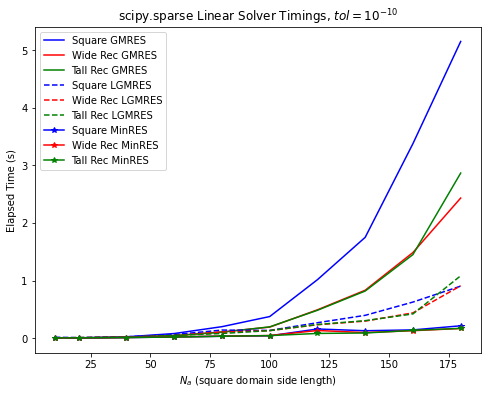

In [45]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, time_square_gmres, '-b', Na_array, time_rect_1_gmres, '-r', Na_array, time_rect_2_gmres, '-g',
        Na_array, time_square_lgmres, '--b', Na_array, time_rect_1_lgmres, '--r', Na_array, time_rect_2_lgmres, '--g',
        Na_array, time_square_minres, '*-b',  Na_array, time_rect_1_minres, '*-r', Na_array, time_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Timings, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])


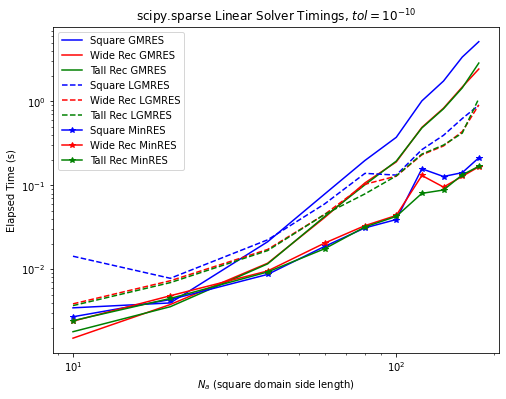

In [46]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, time_square_gmres, '-b', Na_array, time_rect_1_gmres, '-r', Na_array, time_rect_2_gmres, '-g',
        Na_array, time_square_lgmres, '--b', Na_array, time_rect_1_lgmres, '--r', Na_array, time_rect_2_lgmres, '--g',
        Na_array, time_square_minres, '*-b',  Na_array, time_rect_1_minres, '*-r', Na_array, time_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Timings, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])



## # of Iterations plots

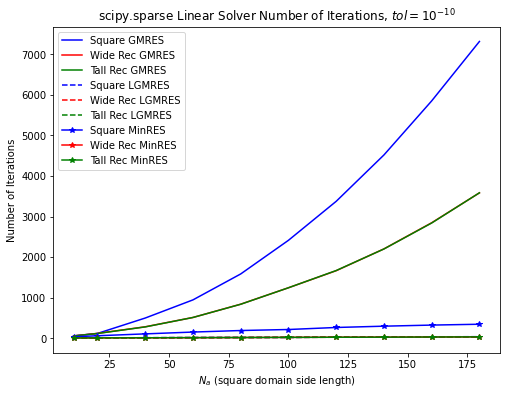

In [47]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, iter_square_gmres, '-b', Na_array, iter_rect_1_gmres, '-r', Na_array, iter_rect_2_gmres, '-g',
        Na_array, iter_square_lgmres, '--b', Na_array, iter_rect_1_lgmres, '--r', Na_array, iter_rect_2_lgmres, '--g',
        Na_array, iter_square_minres, '*-b',  Na_array, iter_rect_1_minres, '*-r', Na_array, iter_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Number of Iterations, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Number of Iterations")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])



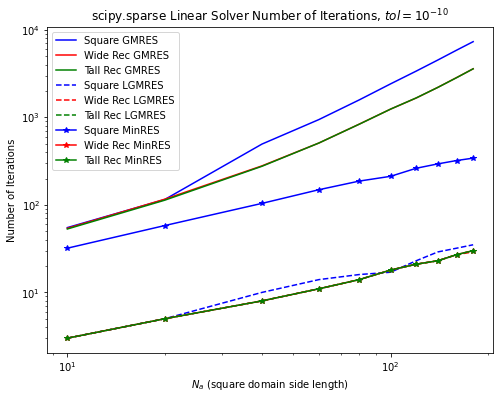

In [48]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, iter_square_gmres, '-b', Na_array, iter_rect_1_gmres, '-r', Na_array, iter_rect_2_gmres, '-g',
        Na_array, iter_square_lgmres, '--b', Na_array, iter_rect_1_lgmres, '--r', Na_array, iter_rect_2_lgmres, '--g',
        Na_array, iter_square_minres, '*-b',  Na_array, iter_rect_1_minres, '*-r', Na_array, iter_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Number of Iterations, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Number of Iterations")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])




## Time per Iteration plots

In [52]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, time_square_gmres/iter_square_gmres, '-b', Na_array, time_rect_1_gmres/iter_rect_1_gmres, '-r', Na_array, time_rect_2_gmres/iter_rect_2_gmres, '-g',
        Na_array, time_square_lgmres/iter_square_lgmres, '--b', Na_array, time_rect_1_lgmres/iter_rect_1_lgmres, '--r', Na_array, time_rect_2_lgmres/iter_rect_2_lgmres, '--g',
        Na_array, time_square_minres/iter_square_minres, '*-b',  Na_array, time_rect_1_minres/iter_rect_1_minres, '*-r', Na_array, time_rect_2_minres/iter_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Time per Iteration, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Time per Iteration (s / iteration)")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])


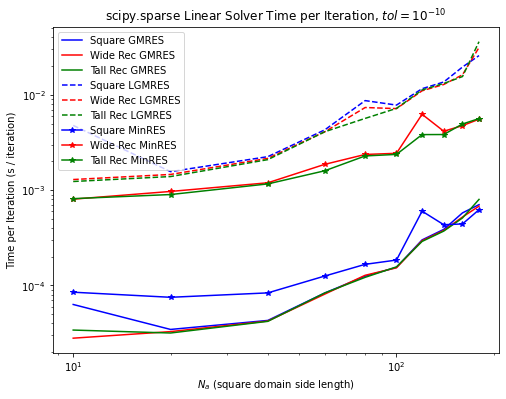

In [54]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, time_square_gmres/iter_square_gmres, '-b', Na_array, time_rect_1_gmres/iter_rect_1_gmres, '-r', Na_array, time_rect_2_gmres/iter_rect_2_gmres, '-g',
        Na_array, time_square_lgmres/iter_square_lgmres, '--b', Na_array, time_rect_1_lgmres/iter_rect_1_lgmres, '--r', Na_array, time_rect_2_lgmres/iter_rect_2_lgmres, '--g',
        Na_array, time_square_minres/iter_square_minres, '*-b',  Na_array, time_rect_1_minres/iter_rect_1_minres, '*-r', Na_array, time_rect_2_minres/iter_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Time per Iteration, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Time per Iteration (s / iteration)")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])



## GMRES vs MinRES Speedup

In [64]:
plt.figure(figsize=(8, 6))
plt.title(r"GMRES vs MinRES Speedup")
plt.ylabel(r"Speedup $:= t_{GMRES} / t_{MinRES}$ ")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.plot(Na_array, time_square_gmres / time_square_minres, '*-b', 
         Na_array, time_rect_1_gmres / time_rect_1_minres, '*-r',
         Na_array, time_rect_2_gmres / time_rect_2_minres, '*-g' )
plt.legend(["Square Domain", "Wide Rec Domain", "Tall Rec Domain"])

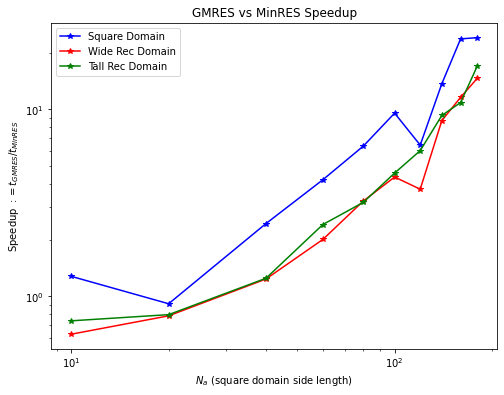

In [65]:
plt.figure(figsize=(8, 6))
plt.title(r"GMRES vs MinRES Speedup")
plt.ylabel(r"Speedup $:= t_{GMRES} / t_{MinRES}$ ")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.loglog(Na_array, time_square_gmres / time_square_minres, '*-b', 
         Na_array, time_rect_1_gmres / time_rect_1_minres, '*-r',
         Na_array, time_rect_2_gmres / time_rect_2_minres, '*-g' )
plt.legend(["Square Domain", "Wide Rec Domain", "Tall Rec Domain"])

## Inverting the 2D Laplacian discretization matrix $A$

In [10]:
# construct A_square's inverses and record time taken
inversion_time = np.array([])

for Na in Na_array[:-4]:
    
    # construct sparse (CSR) square domain Laplacian discretization matrix
    A_square = laplace_matrix_2D_RD(int(Na), int(Na))
    A_square_sparse = scipy.sparse.csr_matrix(A_square)
    
    start = time.time()
    A_inv = scipy.sparse.linalg.inv(A_square_sparse)
    end = time.time()
    inversion_time = np.append(inversion_time, end - start)
    

/Users/orkansezer/opt/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/orkansezer/opt/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [70]:
plt.figure(figsize=(8, 6))
plt.title(r"Number of Time-Steps $N_t$ for $A^{-1}$ Advantage")
plt.ylabel(r"$N_t$ ")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.plot(Na_array[:-4], inversion_time / time_square_gmres[:-4],
        Na_array[:-4], inversion_time / time_square_lgmres[:-4],
        Na_array[:-4], inversion_time / time_square_minres[:-4],
        Na_array[:-4], inversion_time / time_square_qmr[:-4])
plt.legend([r"$N_t$ for GMRES", r"$N_t$ for LGMRES", r"$N_t$ for MinRES", r"$N_t$ for QMR"])

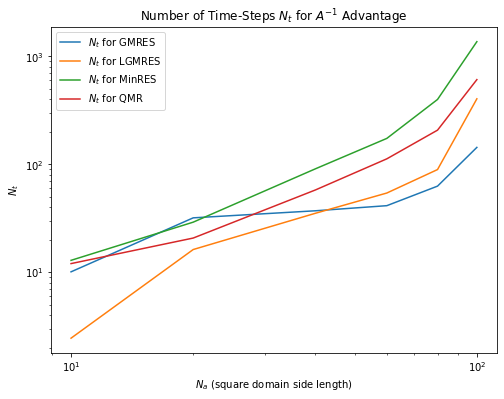

In [72]:
plt.figure(figsize=(8, 6))
plt.title(r"Number of Time-Steps $N_t$ for $A^{-1}$ Advantage")
plt.ylabel(r"$N_t$ ")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.loglog(Na_array[:-4], inversion_time / time_square_gmres[:-4],
        Na_array[:-4], inversion_time / time_square_lgmres[:-4],
        Na_array[:-4], inversion_time / time_square_minres[:-4],
        Na_array[:-4], inversion_time / time_square_qmr[:-4])
plt.legend([r"$N_t$ for GMRES", r"$N_t$ for LGMRES", r"$N_t$ for MinRES", r"$N_t$ for QMR"])

# For 3D

To construct the 3D Laplacian discretization matrix $A$, the function `laplace_matrix_3D_RD()` from the module `CPFM_3D.py` will be used, which will allow for the inspection of effects of domain shape on solver efficiency. Since this function requires that $N_x = N_z$ (a square base) with variable depth $N_y$. Three domain shapes will be considered: cube (e.g. $A$ is $40 \times 40 \times 40$), wide square prism (e.g. $A$ is $80 \times 10 \times 80$), and tall square prism (e.g. $A$ is $20 \times 160 \times 20$). In all cases, to allow for fair comparison (matrix dimensions must be equivalent), the number of grid cells on each domain must be the same.  

In [6]:
def laplace_matrix_3D_RD(Nx, Ny, Nz):
    """
    Creates the 3D Laplacian discretization matrix for a rectangular domain,
        thereby allowing for cases where Nx =/= Ny 
    Input: Nx & Ny & Nz (int), number of grid points on x- & y- & z-axes
    
    ORRRRRR ????? 
    
    Input: Nx, Ny, Nz (int), number of grid points in each respective direction
    
    Output: A_matrix (float array), 3D Laplacian discretization matrix
    """
    
    # initialize the 3D Poisson discretization matrix
    A_matrix = np.zeros((Nx*Ny*Nz, Nx*Ny*Nz))
    
    # add the diagonal entries corresponding to the top and bottom neighbors (of the cells on the main diagonal) respectively
    A_matrix += np.diag(np.ones(Nx * Ny * Nz - Nx), -Nx) + np.diag(np.ones(Nx * Ny * Nz - Nx), Nx) 
    
    # Below, essentially iterate over main diagonal rather than  all entries (cuts computational cost by ~ a square root)
    for i in range(Nx*Ny*Nz): 
        
        # add the main diagonal entries corresponding to the "current" cells
            # all other entries on the same row represent these cells' respective neighborhoods
        A_matrix[i][i] = -6
        
        # add the diagonal entries corresponding to the right neighbors 
        if (i > 0):
            A_matrix[i-1][i] = 1

        # checks if "current" cell is at the end of a row
        if (((i + 1) % Nx == 1) and (i < Nx * Ny * Nz - 1)): 
            
            # "current" cell does NOT have a right neighbor
            A_matrix[i-1][i] = 0

        # add the diagonal entries corresponding to the left neighbors    
        if (i > 0):
            
            A_matrix[i][i-1] = 1

        # checks if "current" cell is at the beginning of a row    
        if (((i + 1) % Nx == 1) and (i > 2)):
            
            # "current" cell does NOT have a left neighbor
            A_matrix[i][i-1] = 0
            
        # checks if "current" cell is at the beginning of a z-layer (depth) 
        if (((i + 1) % (Nx*Ny) == 0) and (i < Nx * Ny * Nz - Nx)):
            
            # reset i (to remove non-existent top and bottom neighbors, all assumed to exist at the beginning)
            i -= Nx-1

            # will use to remove Nx top and Nx bottom neighbors            
            cntr = 0
            
            while (cntr < Nx):
                
                A_matrix[i+cntr+Nx][i+cntr] = 0 # "current" cell does NOT have a top neighbor
                A_matrix[i+cntr][i+cntr+Nx] = 0 # "current" cell does NOT have a bottom neighbor
                
                cntr += 1
            
            # set i back to pre-while loop value
            i += Nx-1

    # add the diagonal entries corresponding to the front and back neighbors (of the cells on the main diagonal) respectively       
    A_matrix += np.diag(np.ones(Nx * Ny * Nz - Nx * Ny), -Nx*Ny) + np.diag(np.ones(Nx * Ny * Nz - Nx * Ny), Nx*Ny)
    
    return A_matrix

In [17]:
# tested domain sizes as Na, adjust Nx, Ny, and Nz accordingly
dimension_list = [16, 20, 24, 28, 32]


In [19]:
# initialize plotting arrays
Na_array = np.array([])
iter_square_gmres = np.array([]) # GMRES
time_square_gmres = np.array([])
e_RMS_square_gmres = np.array([])
iter_rect_1_gmres = np.array([])
time_rect_1_gmres = np.array([])
e_RMS_rect_1_gmres = np.array([])
iter_rect_2_gmres = np.array([])
time_rect_2_gmres = np.array([])
e_RMS_rect_2_gmres = np.array([])
iter_square_lgmres = np.array([]) # LGMRES
time_square_lgmres = np.array([])
e_RMS_square_lgmres = np.array([])
iter_rect_1_lgmres = np.array([])
time_rect_1_lgmres = np.array([])
e_RMS_rect_1_lgmres = np.array([])
iter_rect_2_lgmres = np.array([])
time_rect_2_lgmres = np.array([])
e_RMS_rect_2_lgmres = np.array([])
iter_square_minres = np.array([]) # MinRES
time_square_minres = np.array([])
e_RMS_square_minres = np.array([])
iter_rect_1_minres = np.array([])
time_rect_1_minres = np.array([])
e_RMS_rect_1_minres = np.array([])
iter_rect_2_minres = np.array([])
time_rect_2_minres = np.array([])
e_RMS_rect_2_minres = np.array([])
iter_square_qmr = np.array([]) # QMR
time_square_qmr = np.array([])
e_RMS_square_qmr = np.array([])
iter_rect_1_qmr = np.array([])
time_rect_1_qmr = np.array([])
e_RMS_rect_1_qmr = np.array([])
iter_rect_2_qmr = np.array([])
time_rect_2_qmr = np.array([])
e_RMS_rect_2_qmr = np.array([])


for i in range(len(dimension_list)):
    
    Na = dimension_list[i]
    
    # for tall square prism
    Nx1 = int(Na/2)
    Nz1 = Nx1
    Ny1 = int(Na * 4)
    
    # for wide square prism
    Nx2 = int(Na * 2)
    Nz2 = Nx2
    Ny2 = int(Na/4)
    
    
    assert(Na**3 == Nx1*Ny1*Nz1), "Number of cube and tall square prism domain grid cells do NOT match..."
    assert(Na**3 == Nx2*Ny2*Nz2), "Number of cube and wide square prism domain grid cells do NOT match..."
    
    # construct random RHS vector
    vec_RHS = np.random.rand(Na**3)
    
    # construct sparse (CSR) cube domain Laplacian discretization matrix
    A_square = laplace_matrix_3D_RD(Na, Na, Na)
    A_square_sparse = scipy.sparse.csr_matrix(A_square)
    
    # construct sparse (CSR) wide square prism domain (rect 1) Laplacian discretization matrix
    A_rect_1 = laplace_matrix_3D_RD(Nx2, Ny2, Nz2)
    A_rect_1_sparse = scipy.sparse.csr_matrix(A_rect_1)
    
    # construct sparse (CSR) tall square prism domain (rect 2) Laplacian discretization matrix
    A_rect_2 = laplace_matrix_3D_RD(Nx1, Ny1, Nz1)
    A_rect_2_sparse = scipy.sparse.csr_matrix(A_rect_2)
    
    
    # Data generation/collection portion : 
    Na_array = np.append(Na_array, Na)
    
    # For GMRES:
    # Square GMRES
    start = time.time() # start time
    solution_gmres, s_gmres, iter_gmres = iterations_gmres(A_square_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_sparse @ solution_gmres)**2))
    
    iter_square_gmres = np.append(iter_square_gmres, iter_gmres)
    time_square_gmres = np.append(time_square_gmres, end - start)
    e_RMS_square_gmres = np.append(e_RMS_square_gmres, e_RMS)
    
    # Rect 1 GMRES
    start = time.time() # start time
    solution_gmres, s_gmres, iter_gmres = iterations_gmres(A_rect_1_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_1_sparse @ solution_gmres)**2))
    
    iter_rect_1_gmres = np.append(iter_rect_1_gmres, iter_gmres)
    time_rect_1_gmres = np.append(time_rect_1_gmres, end - start)
    e_RMS_rect_1_gmres = np.append(e_RMS_rect_1_gmres, e_RMS)
    
    # Rect 2 GMRES
    start = time.time() # start time
    solution_gmres, s_gmres, iter_gmres = iterations_gmres(A_rect_2_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_2_sparse @ solution_gmres)**2))
    
    iter_rect_2_gmres = np.append(iter_rect_2_gmres, iter_gmres)
    time_rect_2_gmres = np.append(time_rect_2_gmres, end - start)
    e_RMS_rect_2_gmres = np.append(e_RMS_rect_2_gmres, e_RMS)
    
    
    # For LGMRES:
    # Square LGMRES
    start = time.time() # start time
    solution_lgmres, s_lgmres, iter_lgmres = iterations_lgmres(A_square_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_sparse @ solution_lgmres)**2))
    
    iter_square_lgmres = np.append(iter_square_lgmres, iter_lgmres)
    time_square_lgmres = np.append(time_square_lgmres, end - start)
    e_RMS_square_lgmres = np.append(e_RMS_square_lgmres, e_RMS)
    
    # Rect 1 GMRES
    start = time.time() # start time
    solution_lgmres, s_lgmres, iter_lgmres = iterations_lgmres(A_rect_1_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_1_sparse @ solution_lgmres)**2))
    
    iter_rect_1_lgmres = np.append(iter_rect_1_lgmres, iter_lgmres)
    time_rect_1_lgmres = np.append(time_rect_1_lgmres, end - start)
    e_RMS_rect_1_lgmres = np.append(e_RMS_rect_1_lgmres, e_RMS)
    
    # Rect 2 GMRES
    start = time.time() # start time
    solution_lgmres, s_lgmres, iter_lgmres = iterations_lgmres(A_rect_2_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_2_sparse @ solution_lgmres)**2))
    
    iter_rect_2_lgmres = np.append(iter_rect_2_lgmres, iter_lgmres)
    time_rect_2_lgmres = np.append(time_rect_2_lgmres, end - start)
    e_RMS_rect_2_lgmres = np.append(e_RMS_rect_2_lgmres, e_RMS)
    
    
    # For MinRES:
    # Square MinRES
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_square_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_sparse @ solution_minres)**2))
    
    iter_square_minres = np.append(iter_square_minres, iter_minres)
    time_square_minres = np.append(time_square_minres, end - start)
    e_RMS_square_minres = np.append(e_RMS_square_minres, e_RMS)
    
    # Rect 1 MinRES
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_rect_1_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_1_sparse @ solution_minres)**2))
    
    iter_rect_1_minres = np.append(iter_rect_1_minres, iter_lgmres)
    time_rect_1_minres = np.append(time_rect_1_minres, end - start)
    e_RMS_rect_1_minres = np.append(e_RMS_rect_1_minres, e_RMS)
    
    # Rect 2 MinRES
    start = time.time() # start time
    solution_minres, s_minres, iter_minres = iterations_minres(A_rect_2_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_2_sparse @ solution_minres)**2))
    
    iter_rect_2_minres = np.append(iter_rect_2_minres, iter_lgmres)
    time_rect_2_minres = np.append(time_rect_2_minres, end - start)
    e_RMS_rect_2_minres = np.append(e_RMS_rect_2_minres, e_RMS)
    
    
    # For QMR
    # Square QMR
    start = time.time() # start time
    solution_qmr, s_qmr, iter_qmr = iterations_qmr(A_square_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_sparse @ solution_qmr)**2))
    
    iter_square_qmr = np.append(iter_square_qmr, iter_qmr)
    time_square_qmr = np.append(time_square_qmr, end - start)
    e_RMS_square_qmr = np.append(e_RMS_square_qmr, e_RMS)
    
    # Rect 1 QMR
    start = time.time() # start time
    solution_qmr, s_qmr, iter_qmr = iterations_qmr(A_rect_1_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_1_sparse @ solution_qmr)**2))
    
    iter_rect_1_qmr = np.append(iter_rect_1_qmr, iter_lgmres)
    time_rect_1_qmr = np.append(time_rect_1_qmr, end - start)
    e_RMS_rect_1_qmr = np.append(e_RMS_rect_1_qmr, e_RMS)
    
    # Rect 2 QMR
    start = time.time() # start time
    solution_qmr, s_qmr, iter_qmr = iterations_qmr(A_rect_2_sparse, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_rect_2_sparse @ solution_qmr)**2))
    
    iter_rect_2_qmr = np.append(iter_rect_2_qmr, iter_qmr)
    time_rect_2_qmr = np.append(time_rect_2_qmr, end - start)
    e_RMS_rect_2_qmr = np.append(e_RMS_rect_2_qmr, e_RMS)
       

<ipython-input-5-1af016efafec>:21: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  x,status = scipy.sparse.linalg.lgmres(A, b, tol=1e-10, callback=callback)


## Elapsed Time plots

In [20]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, time_square_gmres, '-b', Na_array, time_rect_1_gmres, '-r', Na_array, time_rect_2_gmres, '-g',
        Na_array, time_square_lgmres, '--b', Na_array, time_rect_1_lgmres, '--r', Na_array, time_rect_2_lgmres, '--g',
        Na_array, time_square_minres, '*-b',  Na_array, time_rect_1_minres, '*-r', Na_array, time_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Timings, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])


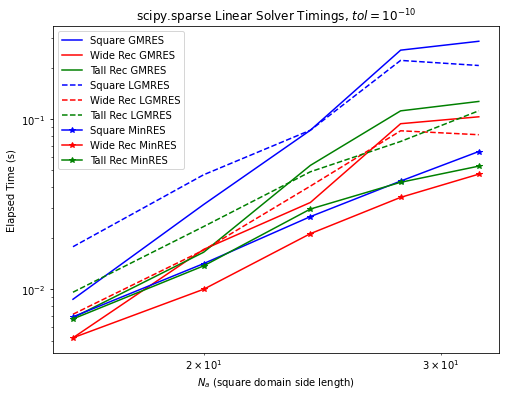

In [21]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, time_square_gmres, '-b', Na_array, time_rect_1_gmres, '-r', Na_array, time_rect_2_gmres, '-g',
        Na_array, time_square_lgmres, '--b', Na_array, time_rect_1_lgmres, '--r', Na_array, time_rect_2_lgmres, '--g',
        Na_array, time_square_minres, '*-b',  Na_array, time_rect_1_minres, '*-r', Na_array, time_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Timings, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])


## # of Iterations plots

In [22]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, iter_square_gmres, '-b', Na_array, iter_rect_1_gmres, '-r', Na_array, iter_rect_2_gmres, '-g',
        Na_array, iter_square_lgmres, '--b', Na_array, iter_rect_1_lgmres, '--r', Na_array, iter_rect_2_lgmres, '--g',
        Na_array, iter_square_minres, '*-b',  Na_array, iter_rect_1_minres, '*-r', Na_array, iter_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Number of Iterations, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Number of Iterations")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])




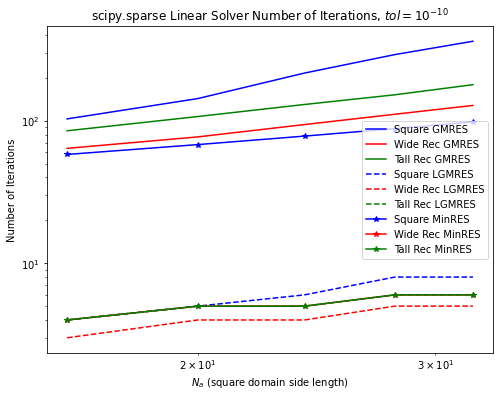

In [23]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, iter_square_gmres, '-b', Na_array, iter_rect_1_gmres, '-r', Na_array, iter_rect_2_gmres, '-g',
        Na_array, iter_square_lgmres, '--b', Na_array, iter_rect_1_lgmres, '--r', Na_array, iter_rect_2_lgmres, '--g',
        Na_array, iter_square_minres, '*-b',  Na_array, iter_rect_1_minres, '*-r', Na_array, iter_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Number of Iterations, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Number of Iterations")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])




## Time per Iteration plots

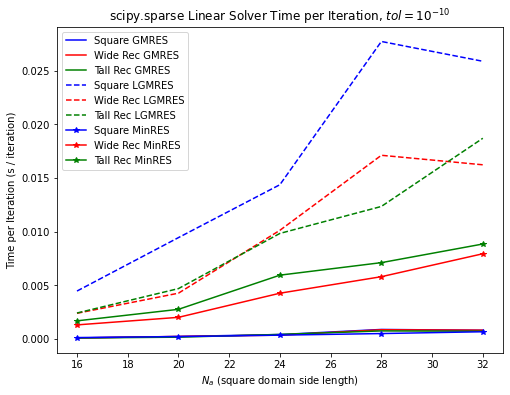

In [24]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, time_square_gmres/iter_square_gmres, '-b', Na_array, time_rect_1_gmres/iter_rect_1_gmres, '-r', Na_array, time_rect_2_gmres/iter_rect_2_gmres, '-g',
        Na_array, time_square_lgmres/iter_square_lgmres, '--b', Na_array, time_rect_1_lgmres/iter_rect_1_lgmres, '--r', Na_array, time_rect_2_lgmres/iter_rect_2_lgmres, '--g',
        Na_array, time_square_minres/iter_square_minres, '*-b',  Na_array, time_rect_1_minres/iter_rect_1_minres, '*-r', Na_array, time_rect_2_minres/iter_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Time per Iteration, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Time per Iteration (s / iteration)")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])


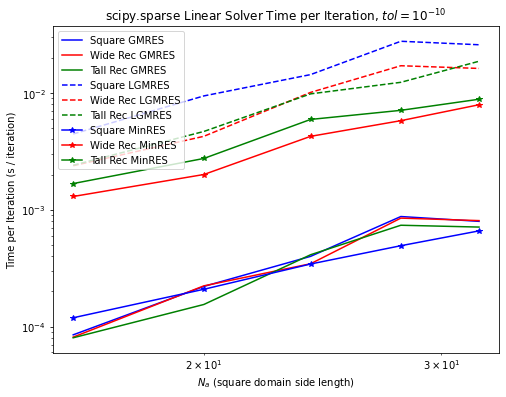

In [25]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, time_square_gmres/iter_square_gmres, '-b', Na_array, time_rect_1_gmres/iter_rect_1_gmres, '-r', Na_array, time_rect_2_gmres/iter_rect_2_gmres, '-g',
        Na_array, time_square_lgmres/iter_square_lgmres, '--b', Na_array, time_rect_1_lgmres/iter_rect_1_lgmres, '--r', Na_array, time_rect_2_lgmres/iter_rect_2_lgmres, '--g',
        Na_array, time_square_minres/iter_square_minres, '*-b',  Na_array, time_rect_1_minres/iter_rect_1_minres, '*-r', Na_array, time_rect_2_minres/iter_rect_2_minres, '*-g')

plt.title(r"scipy.sparse Linear Solver Time per Iteration, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Time per Iteration (s / iteration)")
plt.legend(["Square GMRES", "Wide Rec GMRES", "Tall Rec GMRES", "Square LGMRES", "Wide Rec LGMRES", "Tall Rec LGMRES", "Square MinRES", "Wide Rec MinRES", "Tall Rec MinRES"])




## GMRES vs MinRES Speedup

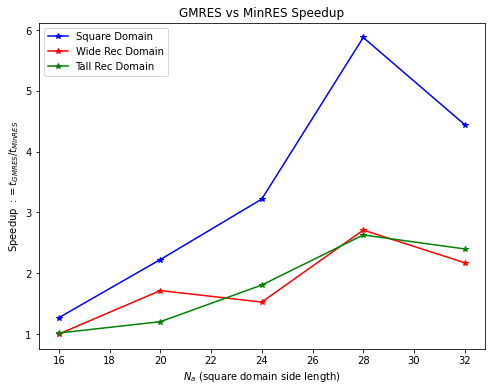

In [26]:
plt.figure(figsize=(8, 6))
plt.title(r"GMRES vs MinRES Speedup")
plt.ylabel(r"Speedup $:= t_{GMRES} / t_{MinRES}$ ")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.plot(Na_array, time_square_gmres / time_square_minres, '*-b', 
         Na_array, time_rect_1_gmres / time_rect_1_minres, '*-r',
         Na_array, time_rect_2_gmres / time_rect_2_minres, '*-g' )
plt.legend(["Square Domain", "Wide Rec Domain", "Tall Rec Domain"])

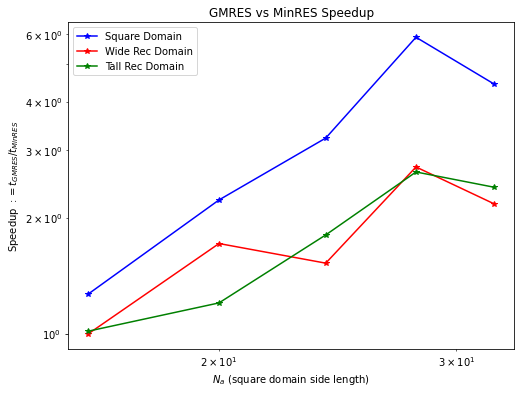

In [27]:
plt.figure(figsize=(8, 6))
plt.title(r"GMRES vs MinRES Speedup")
plt.ylabel(r"Speedup $:= t_{GMRES} / t_{MinRES}$ ")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.loglog(Na_array, time_square_gmres / time_square_minres, '*-b', 
         Na_array, time_rect_1_gmres / time_rect_1_minres, '*-r',
         Na_array, time_rect_2_gmres / time_rect_2_minres, '*-g' )
plt.legend(["Square Domain", "Wide Rec Domain", "Tall Rec Domain"])

## Inverting the 3D Laplacian discretization matrix $A$

In [28]:
# construct A_square's inverses and record time taken
inversion_time = np.array([])

for Na in Na_array[:-2]:
    
    # construct sparse (CSR) square domain Laplacian discretization matrix
    A_square = laplace_matrix_3D_RD(int(Na), int(Na), int(Na))
    A_square_sparse = scipy.sparse.csr_matrix(A_square)
    
    start = time.time()
    A_inv = scipy.sparse.linalg.inv(A_square_sparse)
    end = time.time()
    inversion_time = np.append(inversion_time, end - start)
    

/Users/orkansezer/opt/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/orkansezer/opt/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [29]:
plt.figure(figsize=(8, 6))
plt.title(r"Number of Time-Steps $N_t$ for $A^{-1}$ Advantage")
plt.ylabel(r"$N_t$ ")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.plot(Na_array[:-2], inversion_time / time_square_gmres[:-4],
        Na_array[:-2], inversion_time / time_square_lgmres[:-4],
        Na_array[:-2], inversion_time / time_square_minres[:-4],
        Na_array[:-2], inversion_time / time_square_qmr[:-4])
plt.legend([r"$N_t$ for GMRES", r"$N_t$ for LGMRES", r"$N_t$ for MinRES", r"$N_t$ for QMR"])

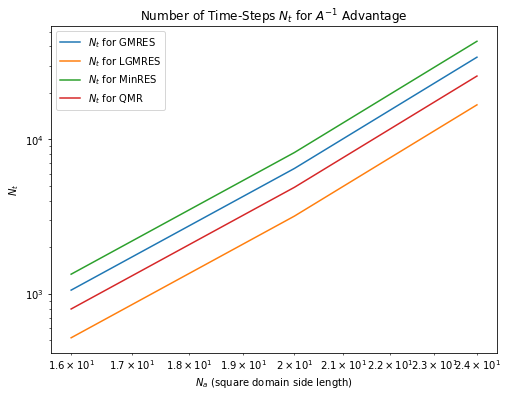

In [31]:
plt.figure(figsize=(8, 6))
plt.title(r"Number of Time-Steps $N_t$ for $A^{-1}$ Advantage")
plt.ylabel(r"$N_t$ ")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.loglog(Na_array[:-2], inversion_time / time_square_gmres[:-4],
        Na_array[:-2], inversion_time / time_square_lgmres[:-4],
        Na_array[:-2], inversion_time / time_square_minres[:-4],
        Na_array[:-2], inversion_time / time_square_qmr[:-4])
plt.legend([r"$N_t$ for GMRES", r"$N_t$ for LGMRES", r"$N_t$ for MinRES", r"$N_t$ for QMR"])